In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.src.layers import InputLayer

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [21]:
import tensorflow as tf
import random

np.random.seed(44)
random.seed(44)
tf.random.set_seed(44)

In [22]:
df = pd.read_csv('test.csv')

In [23]:
X = df.iloc[:, 2:]
y = df['MpKrakZloRog']

# one year
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=44)

# standarization
cols_std = ['rok', 'pm10_7d_avg', 'pm10_30d_avg', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 
            'averageAirTemp', 'averageAirPressure', 'averageWindDirection', 'maxWindSpeed', 'averageWindSpeed']

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[cols_std] = scaler.fit_transform(X_train[cols_std])
X_test_scaled = X_test.copy()
X_test_scaled[cols_std] = scaler.transform(X_test[cols_std])

# normalization
# better for neural network
# outliers are problematic

In [24]:
X_train_scaled = X_train_scaled.values
X_test_scaled = X_test_scaled.values
y_train = y_train.values
y_test = y_test.values

In [29]:
n_input = 7  
n_features = X_train_scaled.shape[1]

train_generator = TimeseriesGenerator(X_train_scaled, y_train, length=n_input, batch_size=4)
test_generator = TimeseriesGenerator(X_test_scaled, y_test, length=n_input, batch_size=4)

model = Sequential()
model.add(InputLayer((n_input, n_features)))
# a relu function doesn't reduce values (like tanh)
# trying different scaler
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.2))    # to avoid overfitting, number of dwitched off neurons
model.add(Dense(1), 'linear')
cp = ModelCheckpoint('modelLSTM.keras', save_best_only=True)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


In [30]:
stats = ['mea', 'mse', 'r2']
df_train = pd.DataFrame(columns=stats)
df_test = pd.DataFrame(columns=stats)

for i in range(6):
    # 30 - overfitting
    model.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=[cp])   
    y_pred = model.predict(test_generator)
    y_pred_train = model.predict(train_generator)
    
    mae = mean_absolute_error(y_train[n_input:], y_pred_train)
    mse = mean_squared_error(y_train[n_input:], y_pred_train)
    r2 = r2_score(y_train[n_input:], y_pred_train)
    df_train.loc[len(df_train)] = [mae, mse, r2]
    
    mae = mean_absolute_error(y_test[n_input:], y_pred)
    mse = mean_squared_error(y_test[n_input:], y_pred)
    r2 = r2_score(y_test[n_input:], y_pred)
    df_test.loc[len(df_test)] = [mae, mse, r2]
    
display(df_train)
display(df_test)

Epoch 1/20


C:\Users\PC\git\AI\PredykcjaSmogu\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


641/641 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1314.1270 - val_loss: 128.2882
Epoch 2/20
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 698.6461 - val_loss: 72.2402
Epoch 3/20
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 394.9232 - val_loss: 70.0169
Epoch 4/20
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 291.9876 - val_loss: 73.0139
Epoch 5/20
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 341.8053 - val_loss: 66.1438
Epoch 6/20
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 253.6451 - val_loss: 69.9545
Epoch 7/20
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 327.5260 - val_loss: 82.7121
Epoch 8/20
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 245.0158 - val_loss: 65.2844
Epoch 9/20
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 369.9652 - val_loss: 65.2149
Epoch 10/20
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 214.1173 - val_loss: 112.2238
Epoch 11/20
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 269.9323 - val_loss: 112.3045
Epoch 12/20
641/641 ━━━━━━

,mea,mse,r2
0,8.202146,159.711805,0.764970
1,7.218118,118.636840,0.825415
2,6.962056,145.158754,0.786386
3,4.972846,56.761726,0.916470
4,3.883122,34.747816,0.948865
5,4.781109,76.787716,0.887000


,mea,mse,r2
0,5.755128,66.774909,0.438126
1,5.920172,81.771740,0.311936
2,6.281526,89.302319,0.248570
3,6.270428,88.691967,0.253706
4,6.799549,97.579807,0.178919
5,6.262952,80.616908,0.321653


In [31]:
# stochastic process -> different oucomes
#tf.config.experimental.enable_op_determinism()
#tf.keras.utils.set_random_seed(44)
model.fit(train_generator, epochs=25, validation_data=test_generator)

Epoch 1/25
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 79.5402 - val_loss: 75.5026
Epoch 2/25
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 68.7856 - val_loss: 77.5033
Epoch 3/25
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 52.4383 - val_loss: 72.1793
Epoch 4/25
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 101.8012 - val_loss: 78.1410
Epoch 5/25
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 61.3076 - val_loss: 80.4043
Epoch 6/25
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 113.1749 - val_loss: 91.2349
Epoch 7/25
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 59.6449 - val_loss: 95.1161
Epoch 8/25
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 38.6568 - val_loss: 84.0432
Epoch 9/25
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 66.7227 - val_loss: 87.2120
Epoch 10/25
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 45.4627 - val_loss: 90.7530
Epoch 11/25
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 56.5054 - val_loss: 90.9196
Epoch 12/25
641/641 ━━━━━━━━

In [83]:
# Make predictions
y_pred = model.predict(test_generator)
y_pred_train = model.predict(train_generator)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [84]:
# training
mae = mean_absolute_error(y_train[n_input:], y_pred_train)
mse = mean_squared_error(y_train[n_input:], y_pred_train)
r2 = r2_score(y_train[n_input:], y_pred_train)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

MAE: 9.5854
MSE: 237.4975
R²: 0.6504


losowy rekord :)
MAE: 4.3446
MSE: 31.4727
R²: 0.9537

320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


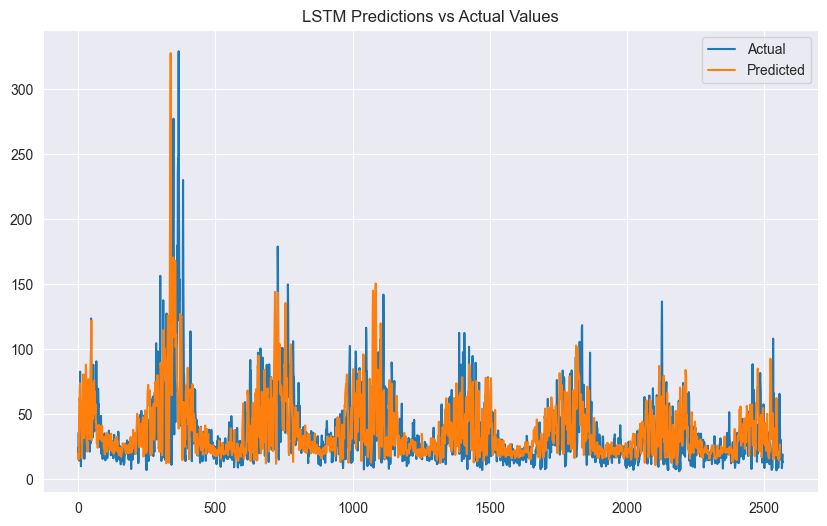

In [85]:
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(model.predict(train_generator), label='Predicted')
plt.legend()
plt.title('LSTM Predictions vs Actual Values')
plt.show()

In [86]:
mae = mean_absolute_error(y_test[n_input:], y_pred)
mse = mean_squared_error(y_test[n_input:], y_pred)
r2 = r2_score(y_test[n_input:], y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

MAE: 5.9998
MSE: 71.1084
R²: 0.4022


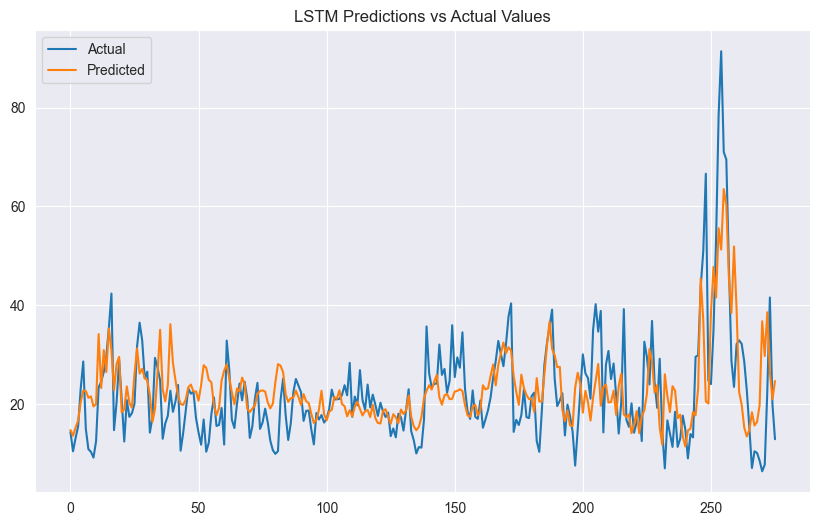

In [87]:
plt.figure(figsize=(10, 6))
plt.plot(y_test[n_input:], label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('LSTM Predictions vs Actual Values')
plt.show()